# Analyzing @LADOTofficial tweets

In [1]:
import pandas as pd
import numpy as np
import requests
from requests import get
import matplotlib.pyplot as plt
import json
import spacy
import seaborn as sns
from time import sleep
import matplotlib.dates as mdates
import env

/usr/local/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Notes:

Hootsuite: https://www.youtube.com/watch?v=Ztk6PXD1EjU

# Twitter API

## Wrangle

In [2]:
data = [
        {
            "id": "17070113",
            "name": "MayorOfLA",
            "username": "MayorOfLA"
        },
        {
            "id": "61261275",
            "name": "LADOT",
            "username": "LADOTofficial"
        },
        {
            "id": "956763276",
            "name": "Nury Martinez",
            "username": "CD6Nury"
        },
        {
            "id": "893602974",
            "name": "Curren D. Price, Jr.",
            "username": "CurrenDPriceJr"
        },
        {
            "id": "341250146",
            "name": "Joe Buscaino",
            "username": "JoeBuscaino"
        }
]

# {
# "id": "1167156666",
# "name": "Gil Cedillo",
# "username": "cmgilcedillo"
# }

In [3]:
twitter_accounts = pd.DataFrame.from_records(data)

In [4]:
twitter_accounts.name = twitter_accounts.name.str.replace('MayorOfLA', 'Eric Garcetti')
twitter_accounts.name = twitter_accounts.name.str.replace('LADOT', 'Los Angeles Department of Transportation')

In [5]:
twitter_accounts

,id,name,username
0,17070113,Eric Garcetti,MayorOfLA
1,61261275,Los Angeles Department of Transportation,LADOTofficial
2,956763276,Nury Martinez,CD6Nury
3,893602974,"Curren D. Price, Jr.",CurrenDPriceJr
4,341250146,Joe Buscaino,JoeBuscaino


In [6]:
url = "https://api.twitter.com/2/users/17070113/tweets?user.fields=created_at,description,entities,id,location,name,pinned_tweet_id,profile_image_url,protected,public_metrics,url,username,verified&max_results=100&start_time=2020-09-30T00:00:00Z&end_time=2020-10-15T00:00:00Z&expansions=&tweet.fields=created_at,public_metrics,source,text"

payload = {}
headers = {"Authorization": "Bearer {}".format(env.bearer_token)}

response = requests.request("GET", url, headers=headers)
response.status_code

tweets = json.loads(response.text.encode('utf8'))['data']

tweets[1]

data = pd.DataFrame()

for tweet in tweets:
    tweet_data = pd.DataFrame({'post_time': pd.to_datetime(tweet['created_at']),
                               'tweet': tweet['text'].lower(),
                               'retweet_count': tweet['public_metrics']['retweet_count'],
                               'reply_count': tweet['public_metrics']['reply_count'],
                               'like_count': tweet['public_metrics']['like_count'],
                               'quote_count': tweet['public_metrics']['quote_count'],
                               'tweet_url_id': tweet['id']
                               },index=[0])
    data = pd.concat([data, tweet_data])

data = data.sort_values(by=['post_time']).reset_index(drop=True)
data = data.assign(
    total_engagement = data[['retweet_count', 'reply_count', 'like_count', 'quote_count']].sum(axis=1)
)

data.head()

,post_time,tweet,retweet_count,reply_count,like_count,quote_count,tweet_url_id,total_engagement
0,2020-09-30 18:57:42+00:00,rt @citylajobs: the city of la offers an onlin...,17,0,0,0,1311379712439058432,17
1,2020-09-30 19:50:15+00:00,check out our new bus lane on aliso st — runni...,12,22,76,2,1311392937096273922,112
2,2020-09-30 21:09:55+00:00,rt @metrolosangeles: views from the purple (d ...,42,0,0,0,1311412984787345408,42
3,2020-09-30 23:18:51+00:00,rt @ladotofficial: a new bus-only lane is maki...,27,0,0,0,1311445435488239616,27
4,2020-10-01 00:34:40+00:00,los angeles always stands with our immigrant c...,66,98,287,25,1311464515502960641,476


## Putting it all together

In [7]:
headers = {"Authorization": "Bearer {}".format(env.bearer_token)}
data = pd.DataFrame()

for index, account in twitter_accounts.iterrows():
    url = f"https://api.twitter.com/2/users/{account['id']}/tweets?user.fields=created_at,description"\
        + ",entities,id,location,name,pinned_tweet_id,profile_image_url,protected,public_metrics"\
        + ",url,username,verified&max_results=100&start_time=2020-09-30T00:00:00Z&end_time=2020-10-15T00:00:00"\
        + "Z&expansions=&tweet.fields=created_at,public_metrics,source,text"
    response = requests.request("GET", url, headers=headers)
    print(f"Acquiring {account['name']}'s tweets")
    sleep(10)
    tweets = json.loads(response.text.encode('utf8'))['data']
    
    for tweet in tweets:
        tweet_data = pd.DataFrame({'post_time': pd.to_datetime(tweet['created_at']),
                                   'id': account['id'],
                                   'name': account['name'],
                                   'username': account['username'],
                                   'tweet': tweet['text'].lower(),
                                   'retweet_count': tweet['public_metrics']['retweet_count'],
                                   'reply_count': tweet['public_metrics']['reply_count'],
                                   'like_count': tweet['public_metrics']['like_count'],
                                   'quote_count': tweet['public_metrics']['quote_count'],
                                   'tweet_url_id': tweet['id']
                                   },index=[0])
        data = pd.concat([data, tweet_data])

Acquiring Eric Garcetti's tweets
Acquiring Los Angeles Department of Transportation's tweets
Acquiring Nury Martinez's tweets
Acquiring Curren D. Price, Jr.'s tweets
Acquiring Joe Buscaino's tweets


In [8]:
data = data.sort_values(by=['post_time']).reset_index(drop=True)
data = data.assign(
    total_engagement = data[['retweet_count', 'reply_count', 'like_count', 'quote_count']].sum(axis=1)
)

In [9]:
data

,post_time,id,name,username,tweet,retweet_count,reply_count,like_count,quote_count,tweet_url_id,total_engagement
0,2020-09-30 16:02:18+00:00,61261275,Los Angeles Department of Transportation,LADOTofficial,a new bus-only lane is making its debut in #do...,27,9,111,8,1311335571097300996,155
1,2020-09-30 17:37:02+00:00,341250146,Joe Buscaino,JoeBuscaino,rt @bsslosangeles: what a difference it makes ...,3,0,0,0,1311359411806375936,3
2,2020-09-30 17:37:59+00:00,341250146,Joe Buscaino,JoeBuscaino,rt @losangeleswalks: safe streets organizing t...,3,0,0,0,1311359653037527040,3
3,2020-09-30 18:57:42+00:00,17070113,Eric Garcetti,MayorOfLA,rt @citylajobs: the city of la offers an onlin...,17,0,0,0,1311379712439058432,17
4,2020-09-30 19:10:52+00:00,893602974,"Curren D. Price, Jr.",CurrenDPriceJr,i partnered with guardaheart to bring crucial ...,0,0,1,1,1311383024559218688,2
...,...,...,...,...,...,...,...,...,...,...,...
167,2020-10-14 20:30:07+00:00,61261275,Los Angeles Department of Transportation,LADOTofficial,have you registered for the great #california ...,1,3,1,0,1316476400401092608,5
168,2020-10-14 20:56:31+00:00,17070113,Eric Garcetti,MayorOfLA,rt @ladotofficial: ⚠️#reminder ⚠️ parking enfo...,48,0,0,0,1316483045227024384,48
169,2020-10-14 20:56:44+00:00,17070113,Eric Garcetti,MayorOfLA,rt @ladotofficial: #ladot has introduced econo...,14,0,0,0,1316483098570186753,14
170,2020-10-14 20:57:10+00:00,956763276,Nury Martinez,CD6Nury,today marks a seminal moment in la history w/ ...,4,3,7,2,1316483208507080705,16


In [10]:
# data.to_csv('tweets.csv', index=False)

In [11]:
df = pd.read_csv('tweets.csv')

In [12]:
df

,post_time,id,name,username,tweet,retweet_count,reply_count,like_count,quote_count,tweet_url_id,total_engagement
0,2020-09-30 16:02:18+00:00,61261275,Los Angeles Department of Transportation,LADOTofficial,a new bus-only lane is making its debut in #do...,27,9,111,8,1311335571097300996,155
1,2020-09-30 17:37:02+00:00,341250146,Joe Buscaino,JoeBuscaino,rt @bsslosangeles: what a difference it makes ...,3,0,0,0,1311359411806375936,3
2,2020-09-30 17:37:59+00:00,341250146,Joe Buscaino,JoeBuscaino,rt @losangeleswalks: safe streets organizing t...,3,0,0,0,1311359653037527040,3
3,2020-09-30 18:57:42+00:00,17070113,Eric Garcetti,MayorOfLA,rt @citylajobs: the city of la offers an onlin...,17,0,0,0,1311379712439058432,17
4,2020-09-30 19:10:52+00:00,893602974,"Curren D. Price, Jr.",CurrenDPriceJr,i partnered with guardaheart to bring crucial ...,0,0,1,1,1311383024559218688,2
...,...,...,...,...,...,...,...,...,...,...,...
167,2020-10-14 20:30:07+00:00,61261275,Los Angeles Department of Transportation,LADOTofficial,have you registered for the great #california ...,1,3,1,0,1316476400401092608,5
168,2020-10-14 20:56:31+00:00,17070113,Eric Garcetti,MayorOfLA,rt @ladotofficial: ⚠️#reminder ⚠️ parking enfo...,48,0,0,0,1316483045227024384,48
169,2020-10-14 20:56:44+00:00,17070113,Eric Garcetti,MayorOfLA,rt @ladotofficial: #ladot has introduced econo...,14,0,0,0,1316483098570186753,14
170,2020-10-14 20:57:10+00:00,956763276,Nury Martinez,CD6Nury,today marks a seminal moment in la history w/ ...,4,3,7,2,1316483208507080705,16


# Explore

In [13]:
non_enforcement_tweets = data.loc[~df.tweet.str.contains('enforcement')]
enforcement_tweets = data.loc[df.tweet.str.contains('enforcement')]

non_enforcement_metrics = non_enforcement_tweets[['post_time', 'total_engagement']]
enforcement_metrics = enforcement_tweets[['post_time', 'total_engagement']]

non_enforcement_metrics.set_index('post_time', inplace=True)
enforcement_metrics.set_index('post_time', inplace=True)



enforcement_metrics = enforcement_metrics.resample('D').sum()
non_enforcement_metrics = non_enforcement_metrics.resample('D').sum()

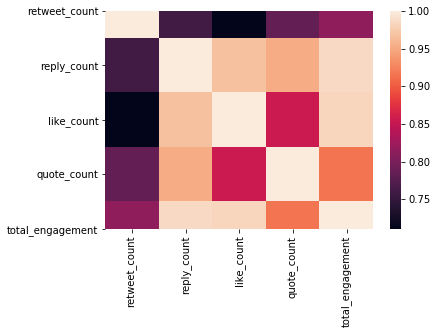

In [14]:
sns.heatmap(enforcement_tweets.corr());

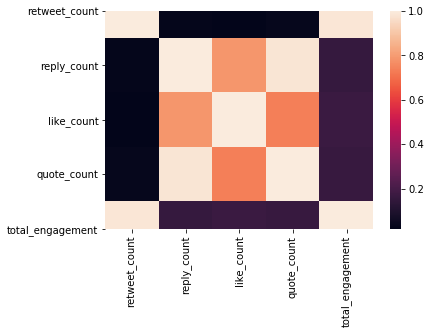

In [15]:
sns.heatmap(non_enforcement_tweets.corr());

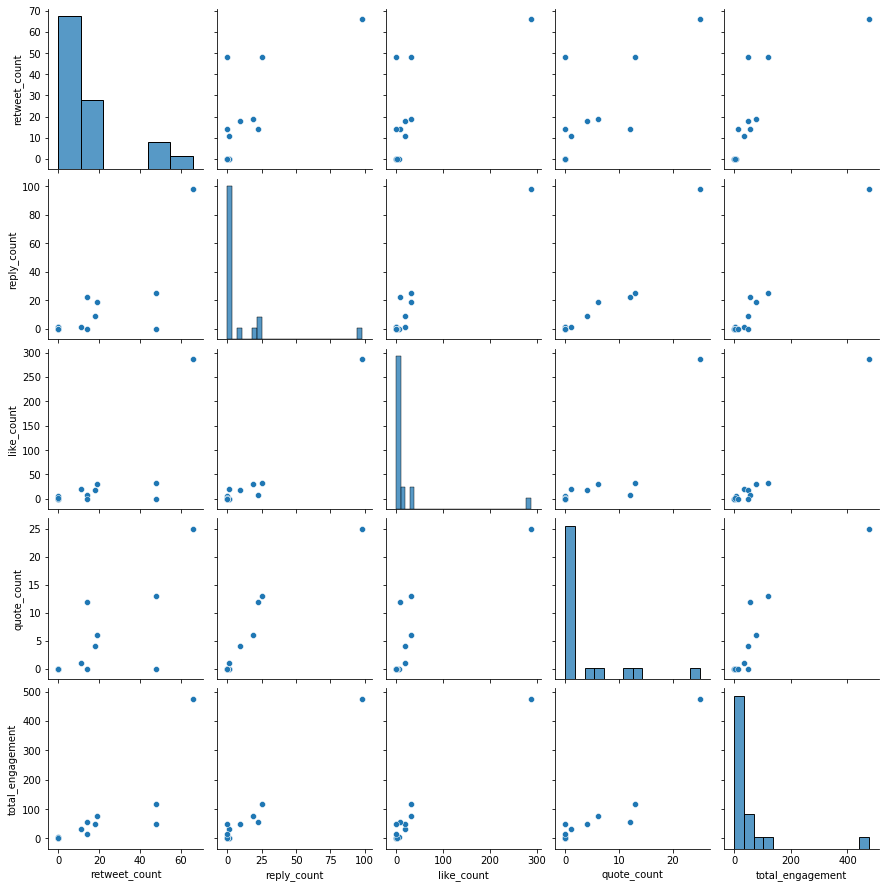

In [16]:
sns.pairplot(enforcement_tweets);

## Tweets from 09-30-2020 through 10-15-2020

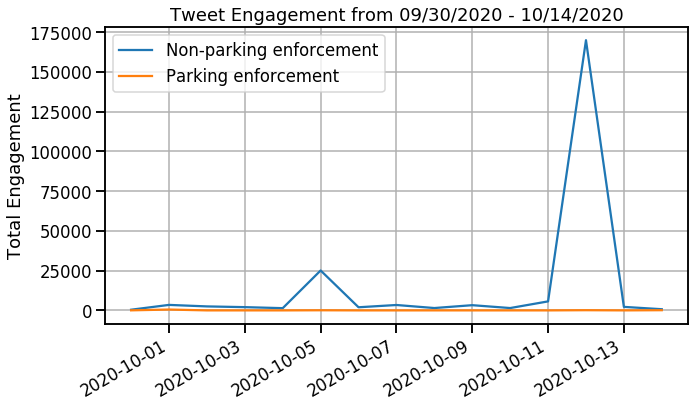

In [100]:
sns.set_context('talk')
plt.figure(figsize=(10, 6))

sns.lineplot(data=non_enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Non-parking enforcement')


sns.lineplot(data=enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Parking enforcement')


plt.title("Tweet Engagement from 09/30/2020 - 10/14/2020")
plt.xlabel('')
plt.ylabel('Total Engagement')

plt.xticks(rotation=30, ha="right")

plt.grid()
plt.tight_layout();

## Who tweeted the most about parking enforcement?

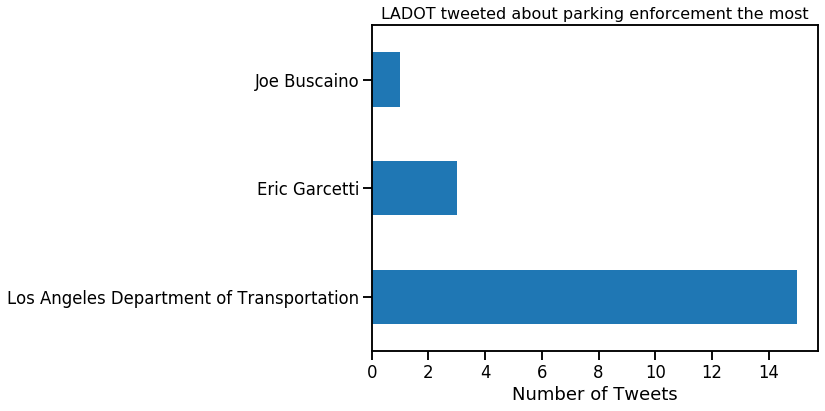

In [128]:
sns.set_context('talk')
enforcement_tweets.groupby('name').size().sort_values(ascending=False).plot.barh(figsize=(8, 6))

plt.title('LADOT tweeted about parking enforcement the most', fontsize=16)
plt.xlabel('Number of Tweets')
plt.ylabel('');

## Who generated the most engagement for parking enforcement?

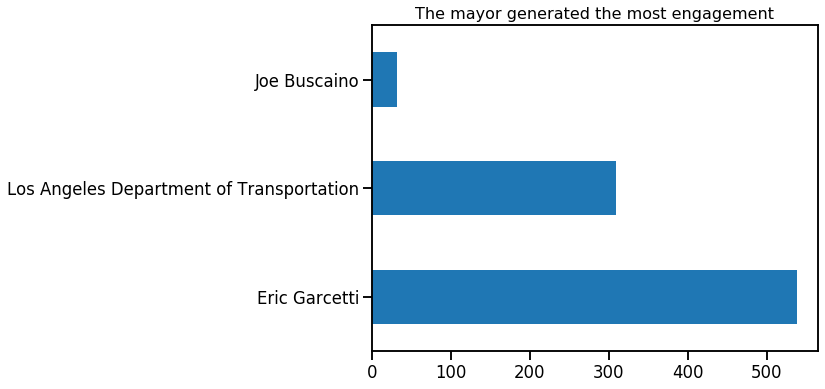

In [127]:
enforcement_tweets.groupby('name').total_engagement.sum().sort_values(ascending=False).plot.barh(figsize=(8, 6))

plt.title('The mayor generated the most engagement', fontsize=16)
plt.ylabel('');

# Appendix

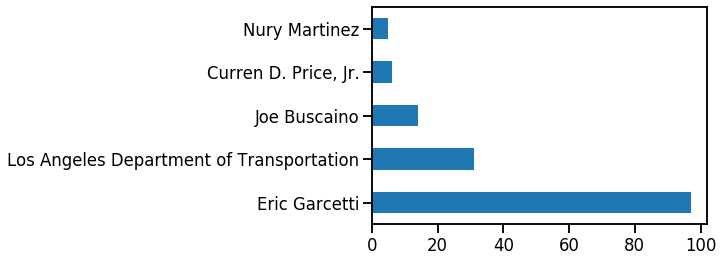

In [120]:
non_enforcement_tweets.groupby('name').size().sort_values(ascending=False).plot.barh()
plt.ylabel('');

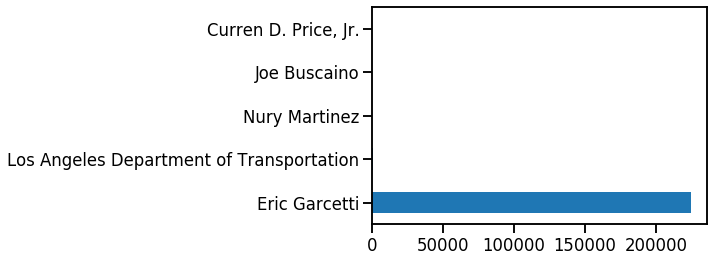

In [116]:
non_enforcement_tweets.groupby('name').total_engagement.sum().sort_values(ascending=False).plot.barh()

plt.ylabel('');

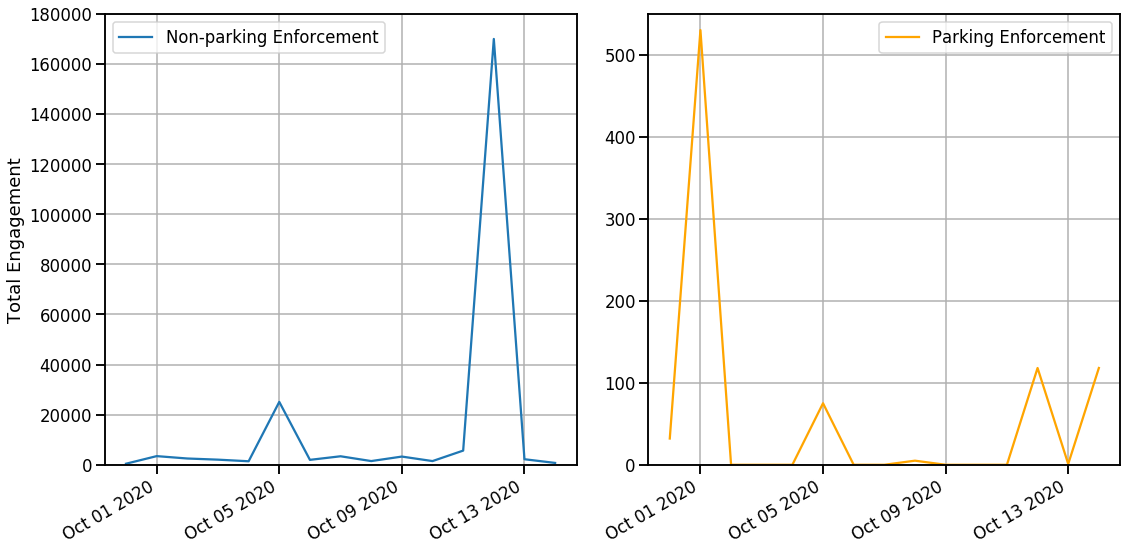

In [92]:
sns.set_context('talk')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.lineplot(data=enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Parking Enforcement',
             color='orange',
             ax=ax2)

sns.lineplot(data=non_enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Non-parking Enforcement',
             ax=ax1)

ax1.grid()
ax2.grid()

ax1.get_xaxis().set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=8))
ax1.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %d %Y"))
plt.setp(ax1.get_xticklabels(), rotation=30, ha="right")

ax2.get_xaxis().set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=8))
ax2.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %d %Y"))
plt.setp(ax2.get_xticklabels(), rotation=30, ha="right")

ax1.set_ylim(0, 180_000)
ax2.set_ylim(0, 550)

ax1.set_xlabel('')
ax2.set_xlabel('')

ax1.set_ylabel('Total Engagement')
ax2.set_ylabel('')

plt.tight_layout();